In [1]:
import os
import numpy as np
import time
import copy
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
from random import sample
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from train_model import train_model, get_n_params
from test_model import test_classifier, show_classifier
from data import load_data
from models import vgg11

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog', pics=None):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        if pics is not None:
            self.image_paths = pics
        else:
            self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [4]:
input_size = 128
batch_size = 12
train_loader, val_loader, test_loader = load_data(batch_size, input_size)

In [7]:
checkpoint = torch.load("Model Checkpoints/vgg11.pth")

In [8]:
model = vgg11(64, input_size)
model.load_state_dict(checkpoint)
model = model.to(device)
model.eval()

test_transform = transforms.Compose([transforms.Resize((input_size, input_size)),
                                     transforms.ToTensor()])

In [9]:
best_out = -99999
iterations = 2000
lr = 0.001
prob_of_hotdog = []

image = Image.open('hotdog_nothotdog/just_trump.jpg')
input_im = torch.autograd.Variable(test_transform(image).unsqueeze(0).cuda(), requires_grad=True)
model.zero_grad()
patience_counter = 0
for i in range(iterations):
    
    output = model(input_im)
    output[:,0].backward()
    prob_of_hotdog.append(torch.exp(output[:,0]))
    input_im.data = input_im.data + lr * input_im.grad.data

    if output[:,0] > best_out:
        best_im = im
        best_out = output[:,0]
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter > 5:
        print(f"Early stopping after {i+1} iterations")
        break

In [10]:
im = input_im.data.squeeze()
im.transpose_(0,1)
im.transpose_(1,2)
im = np.clip(im.cpu().numpy(), 0, 1)
im = Image.fromarray(np.uint8(im*255))

Text(0, 0.5, 'Model Probability of Hotdog')

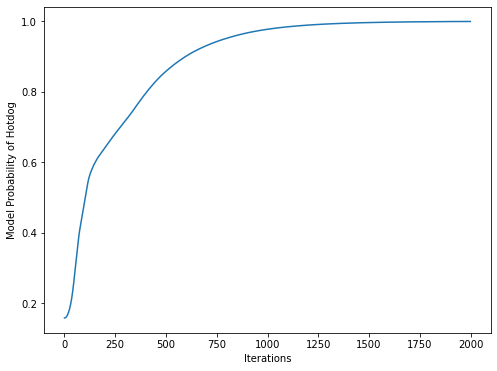

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(prob_of_hotdog)
plt.xlabel('Iterations')
plt.ylabel('Model Probability of Hotdog')

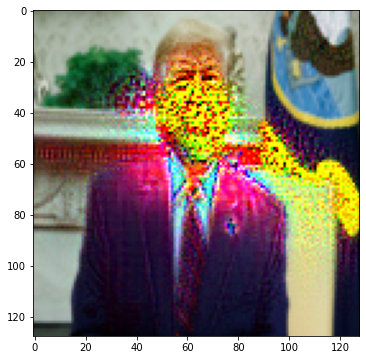

In [12]:
plt.figure(figsize=(8,6))
plt.imshow(im)

In [58]:
len(test_loader.dataset)

1862

In [60]:
len(train_loader.dataset) + len(val_loader.dataset)

2047

In [62]:
prob_of_hotdog[0]

tensor([0.1588], device='cuda:0', grad_fn=<ExpBackward>)